# Hotels Review Sentiment Analysis Project

## Importing Libraries

In [0]:
!pip install wget
import wget

import pandas as pd

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=352466a1ace741a18fc239df6570e1fc0cff5f174e9d84485d3acdeafb2cc460
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Reading and Cleaning Data 

City Chosen- London, Ontario, Canada.

There were a total of 59 hotels on Trip Advisor, however, the crawler was ran for approximately 10 hours and parsed into a csv file.

There are a total of 35 hotels and 6218 reviews from the crawler.

In [0]:
hotelDf= pd.read_csv('https://raw.githubusercontent.com/syedhamdan45/sentiment-analysis-hotels/master/reviews.csv')
hotelDf.columns= ['filePath','hotelName','reviewColumn','ratingScore','groundTruth']
hotelDf.head()

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,data/ca/154995/183771/503334720.html,Delta Hotels by Marriott London Armouries,"""Wonderful, large, bright room, well maintaine...",4,positive
1,data/ca/154995/183771/118665173.html,Delta Hotels by Marriott London Armouries,"""Friendly staff. Varying degrees of updated r...",4,positive
2,data/ca/154995/183771/135210109.html,Delta Hotels by Marriott London Armouries,"""We received a stay as a gift at Christmas and...",2,negative
3,data/ca/154995/183771/490443076.html,Delta Hotels by Marriott London Armouries,"""Great service and great breakfast. Renovated ...",4,positive
4,data/ca/154995/183771/191781503.html,Delta Hotels by Marriott London Armouries,"""You can notify with your own eyes that this h...",5,positive


In [0]:
hotelDf.hotelName= hotelDf.hotelName.str.replace('&amp',"&") #Hotels name had &amp instead of &
hotelDf.hotelName= hotelDf.hotelName.str.replace(';', '') #unnecessary semicolons in the hotel name

hotelDf.reviewColumn= hotelDf.reviewColumn.str.lower()
hotelDf.reviewColumn= hotelDf.reviewColumn.str.replace('"', '')

In [0]:
hotelDf.hotelName.unique()

array(['Delta Hotels by Marriott London Armouries',
       'Fanshawe College Conference Services',
       'Rosneath Bed and Breakfast', 'Hotel Metro', 'Lighthouse Inn',
       'London Extended Stay', 'Econo Lodge',
       'Four Points by Sheraton London', 'Knights Inn London Airport',
       'Best Western Plus Stoneridge Inn & Conference Centre',
       'Wharncliffe Suites', 'Comfort Inn', 'Super 7 Motel',
       'Windermere Manor Hotel & Conference Centre',
       'London Residency Inn', 'Ramada by Wyndham London',
       'Best Western Plus Lamplighter Inn & Conference Centre',
       'London Travel Inn', 'Parkway Motel', 'The Park Hotel London',
       'Maple Glen Motel', 'Motel 6 London Ontario', 'Courtyard London',
       'Holiday Inn Hotel & Suites London', 'Guest House on the Mount',
       'Ivey Spencer Leadership Center', 'Quality Suites London',
       'Residence Inn London Downtown', 'Idlewyld Inn & Spa',
       'Holiday Inn Express & Suites London Downtown',
       'DoubleTr

Removing hotels with less than 20 reviews to avoid bias because of a few reviews. Even with the removal of those hotels, there are enough hotels and reviews for the sentiment analysis.

In [0]:
hotel_count= hotelDf.hotelName.value_counts()<20 #list of hotels with less than 20 reviews
hotel_list= list(hotel_count[hotel_count==True].index)

hotelDf= hotelDf[~hotelDf.hotelName.isin(hotel_list)].reset_index(drop= True)

In [0]:
print("Number of hotels:", hotelDf.hotelName.nunique())
print("Number of reviews:", len(hotelDf))

Number of hotels: 27
Number of reviews: 6152


## Sentiment Analysis and Aggregation

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
reviews = hotelDf['reviewColumn'].values
reviewDf = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 6152/6152 [00:07<00:00, 862.35it/s]


In [0]:
reviewDf.head()

,reviewCol,vader
0,"wonderful, large, bright room, well maintained...",0.9248
1,friendly staff. varying degrees of updated ro...,0.8968
2,we received a stay as a gift at christmas and ...,0.8719
3,great service and great breakfast. renovated r...,0.8481
4,you can notify with your own eyes that this ho...,0.9777


In [0]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+') 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk, finalDf = dataFrameTransformation(hotelDf, reviewDf, k=500)

In [0]:
finalDf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,room,hotel,staff,stay,great,clean,would,rooms,good,london,breakfast,nice,stayed,friendly,one,comfortable,well,night,pool,service,desk,time,front,place,area,location,food,nthe,bed,restaurant,like,get,also,back,could,...,complaint,maintained,almost,variety,cost,upgraded,future,meals,met,greeted,exceptional,name,hallways,walked,probably,received,house,fact,beyond,arrival,management,bath,maybe,setting,items,spot,inside,wish,change,maker,window,smoke,white,forward,venue,often,sunday,leave,areas,style
0,Delta Hotels by Marriott London Armouries,4,positive,"wonderful, large, bright room, well maintained...",0.9248,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Delta Hotels by Marriott London Armouries,4,positive,friendly staff. varying degrees of updated ro...,0.8968,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Delta Hotels by Marriott London Armouries,2,negative,we received a stay as a gift at christmas and ...,0.8719,1,1,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Delta Hotels by Marriott London Armouries,4,positive,great service and great breakfast. renovated r...,0.8481,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Delta Hotels by Marriott London Armouries,5,positive,you can notify with your own eyes that this ho...,0.9777,1,1,1,0,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### (a) Average Vader and average ground truth rating per hotel

In [0]:
sentimentAnalysisDf = finalDf[['hotelName', 'ratingScore', 'vader']]

In [0]:
sentimentAnalysisDf= sentimentAnalysisDf.groupby('hotelName', as_index=True).mean()
sentimentAnalysisDf.head()

,ratingScore,vader
hotelName,,
Best Western Plus Lamplighter Inn & Conference Centre,4.499394,0.839944
Best Western Plus Stoneridge Inn & Conference Centre,4.147170,0.769336
Comfort Inn,3.413333,0.643128
Courtyard London,4.000000,0.586474
Days Inn by Wyndham London,3.306452,0.485699


### (b) Hotels ranking

By vader and ground truth rating- top 5 and bottom 5

In [0]:
top5rating= sentimentAnalysisDf.sort_values('ratingScore', ascending= False).head(5)
top5rating.drop(columns= ['vader'])

,ratingScore
hotelName,
Idlewyld Inn & Spa,4.731915
Hotel Metro,4.561905
Best Western Plus Lamplighter Inn & Conference Centre,4.499394
TownePlace Suites by Marriott London,4.452632
Ivey Spencer Leadership Center,4.415827


In [0]:
top5vader= sentimentAnalysisDf.sort_values('vader', ascending= False).head(5)
top5vader.drop(columns= ['ratingScore'])

,vader
hotelName,
Idlewyld Inn & Spa,0.930610
Hotel Metro,0.865974
Windermere Manor Hotel & Conference Centre,0.852148
Best Western Plus Lamplighter Inn & Conference Centre,0.839944
Ivey Spencer Leadership Center,0.822471


In [0]:
bottom5rating= sentimentAnalysisDf.sort_values('ratingScore').head(5)
bottom5rating.drop(columns= ['vader'])

,ratingScore
hotelName,
London Extended Stay,2.457143
Super 7 Motel,2.500000
London Travel Inn,3.275641
Days Inn by Wyndham London,3.306452
Motor Court Motel,3.350000


In [0]:
bottom5vader= sentimentAnalysisDf.sort_values('vader').head(5)
bottom5vader.drop(columns=['ratingScore'])

,vader
hotelName,
Super 7 Motel,0.214317
London Extended Stay,0.255856
Motor Court Motel,0.413970
Days Inn by Wyndham London,0.485699
London Travel Inn,0.514367


In [0]:
hotelRankDf= pd.DataFrame([top5vader.index, top5rating.index, bottom5vader.index, bottom5rating.index]).T
hotelRankDf.columns= ['Top 5 Vader', "Top 5 Ground Truth Rating", "Bottom 5 Vader", "Bottom 5 Ground Truth Rating"]
hotelRankDf

,Top 5 Vader,Top 5 Ground Truth Rating,Bottom 5 Vader,Bottom 5 Ground Truth Rating
0,Idlewyld Inn & Spa,Idlewyld Inn & Spa,Super 7 Motel,London Extended Stay
1,Hotel Metro,Hotel Metro,London Extended Stay,Super 7 Motel
2,Windermere Manor Hotel & Conference Centre,Best Western Plus Lamplighter Inn & Conference...,Motor Court Motel,London Travel Inn
3,Best Western Plus Lamplighter Inn & Conference...,TownePlace Suites by Marriott London,Days Inn by Wyndham London,Days Inn by Wyndham London
4,Ivey Spencer Leadership Center,Ivey Spencer Leadership Center,London Travel Inn,Motor Court Motel


The top 2 are the same for both Vader and Ground Truth rating. Windermere (via Vader) and TownePlace (via Ground Truth) is not present in the other list. 

For the bottom ranks, the ranking might be different but they are all present in the two list.

It should be noted that some hotels that were previously in the top or bottom 5 had very few reviews and hence the condition of having at least 20+ reviews was implemented. For example, Rosneath has only 10 reviews (and was ranked first in the Top List) and London Residency Inn has only 1 review (and was ranked first in the Bottom List). Having low reviews could mean there is bias since its been rated by a few people only.

## Word Frequency Analysis

### (a) Term Frequency for positive and negative reviews (ground truth)

In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('would')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+') 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [0]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finalDf[['reviewCol','groundTruth','vader']]

In [0]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')
topkGroundPos

[('great', 2841),
 ('clean', 2297),
 ('london', 1905),
 ('good', 1786),
 ('breakfast', 1653),
 ('nice', 1617),
 ('friendly', 1530),
 ('stayed', 1463),
 ('comfortable', 1448),
 ('well', 1316),
 ('pool', 1262),
 ('service', 1246),
 ('one', 1177),
 ('area', 1058),
 ('food', 1043),
 ('time', 1039),
 ('place', 1018),
 ('location', 978),
 ('restaurant', 977),
 ('night', 976),
 ('excellent', 960),
 ('desk', 935),
 ('helpful', 890),
 ('front', 875),
 ('nthe', 843),
 ('bed', 798),
 ('recommend', 774),
 ('like', 767),
 ('also', 759),
 ('parking', 725),
 ('back', 715),
 ('check', 712),
 ('definitely', 679),
 ('really', 669),
 ('get', 623),
 ('quiet', 618),
 ('always', 601),
 ('close', 601),
 ('beautiful', 593),
 ('best', 593),
 ('could', 585),
 ('everything', 568),
 ('little', 560),
 ('beds', 559),
 ('family', 544),
 ('large', 539),
 ('free', 532),
 ('day', 516),
 ('even', 508),
 ('next', 499)]

In [0]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')
topkGroundNeg

[('one', 600),
 ('night', 599),
 ('desk', 530),
 ('breakfast', 517),
 ('clean', 500),
 ('good', 494),
 ('stayed', 466),
 ('front', 464),
 ('get', 440),
 ('could', 434),
 ('nice', 402),
 ('like', 371),
 ('bed', 368),
 ('time', 367),
 ('door', 344),
 ('nthe', 336),
 ('even', 320),
 ('place', 320),
 ('pool', 310),
 ('back', 309),
 ('london', 298),
 ('check', 296),
 ('floor', 292),
 ('told', 284),
 ('also', 279),
 ('great', 271),
 ('well', 270),
 ('parking', 264),
 ('next', 261),
 ('bathroom', 261),
 ('people', 257),
 ('friendly', 255),
 ('first', 252),
 ('service', 245),
 ('old', 245),
 ('morning', 242),
 ('location', 235),
 ('said', 232),
 ('booked', 230),
 ('went', 226),
 ('comfortable', 225),
 ('got', 225),
 ('area', 223),
 ('price', 219),
 ('never', 218),
 ('day', 207),
 ('around', 206),
 ('really', 198),
 ('small', 194),
 ('little', 188)]

Positive terms are defined by word such as great, clean, good, etc. It is important to note that some of these words do not describe well on its own. For example, breakfast, pool, parking could be accompanied by other terms such as free, good, etc.

Negative terms include desk, front (this could indicate the front desk used together). Again, it also has similar terms such as breakfast, good, nice which could be accompanied by other terms such as bad breakfast, not good, not nice, etc. 
It is important to read the reviews that have those terms to get a better understanding of the sentiment. However, this has helped us indicate that perhaps the front desk could be a major issue for the negative sentiment in the hotels.

Locale specific words include london, location, etc

### (b) Analysis repeated for noun phrases

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [0]:
tagger = PerceptronTagger()
pos_tag = tagger.tag
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

NP: Noun Phrase
JJ: adjective
RB: adverb

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w)]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDf)

In [0]:
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,front desk,pool area,front desk staff,great place,hot tub,nthe room,london ontario,great locat,next time,first time,park lot,next morn,hotel room,hotel staff,downtown london,hotel metro,friendli staff,comfort bed,great stay,continent breakfast,room servic,night stay,hockey tournament,water slide,great hotel,breakfast buffet,custom servic,next day,nthe hotel,clean room,good valu,free breakfast,dine room,great experi,nice hotel,busi trip,second floor,clean staff,nthe staff,complimentari breakfast,good locat,london area,hockey team,staff member,great servic,great valu,first night,queen bed,nice touch,reason price
0,Delta Hotels by Marriott London Armouries,4,positive,"wonderful, large, bright room, well maintained...",0.9248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Delta Hotels by Marriott London Armouries,4,positive,friendly staff. varying degrees of updated ro...,0.8968,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Delta Hotels by Marriott London Armouries,2,negative,we received a stay as a gift at christmas and ...,0.8719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Delta Hotels by Marriott London Armouries,4,positive,great service and great breakfast. renovated r...,0.8481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Delta Hotels by Marriott London Armouries,5,positive,you can notify with your own eyes that this ho...,0.9777,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
def getTopKNounPhrases(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('would')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))
    topk = counter.most_common(k)
    return topk

In [0]:
NounAnalysisDf= finaldf_phrase[['reviewCol','groundTruth','vader']]

In [0]:
topkNounGroundPos = getTopKNounPhrases(df=NounAnalysisDf, k=50, label_value='positive')
topkNounGroundPos

[('front desk', 339),
 ('pool area', 164),
 ('great place', 135),
 ('front desk staff', 127),
 ('hot tub', 103),
 ('london ontario', 97),
 ('next time', 86),
 ('great locat', 83),
 ('nthe room', 80),
 ('hotel metro', 80),
 ('great stay', 78),
 ('downtown london', 76),
 ('first time', 76),
 ('hotel staff', 70),
 ('friendli staff', 69),
 ('comfort bed', 68),
 ('room servic', 66),
 ('great hotel', 66),
 ('water slide', 62),
 ('hotel room', 59),
 ('next morn', 58),
 ('breakfast buffet', 57),
 ('great experi', 57),
 ('dine room', 55),
 ('night stay', 53),
 ('continent breakfast', 51),
 ('custom servic', 50),
 ('nice hotel', 49),
 ('great servic', 47),
 ('great valu', 46),
 ('clean room', 46),
 ('nthe staff', 46),
 ('good valu', 45),
 ('london area', 45),
 ('hockey tournament', 44),
 ('nthe hotel', 44),
 ('busi trip', 43),
 ('park lot', 42),
 ('delta london armouri', 42),
 ('great time', 41),
 ('free breakfast', 41),
 ('reason price', 40),
 ('meet room', 39),
 ('nice touch', 39),
 ('king sui

In [0]:
topkNounGroundNeg = getTopKNounPhrases(df=NounAnalysisDf, k=50, label_value='negative')
topkNounGroundNeg

[('front desk', 222),
 ('park lot', 53),
 ('front desk staff', 40),
 ('next morn', 35),
 ('nthe room', 34),
 ('pool area', 33),
 ('hotel room', 33),
 ('next day', 32),
 ('hot tub', 32),
 ('credit card', 29),
 ('first night', 28),
 ('hockey tournament', 28),
 ('continent breakfast', 26),
 ('second floor', 25),
 ('night stay', 22),
 ('hotel staff', 21),
 ('non smoke room', 21),
 ('free breakfast', 20),
 ('first time', 20),
 ('first floor', 20),
 ('great locat', 19),
 ('nthe hotel', 19),
 ('clean staff', 19),
 ('coffe maker', 19),
 ('smoke room', 19),
 ('next door', 18),
 ('hockey team', 18),
 ('second night', 17),
 ('air condition', 17),
 ('custom servic', 17),
 ('complimentari breakfast', 16),
 ('good valu', 16),
 ('hot water', 15),
 ('london ontario', 15),
 ('clean room', 15),
 ('busi trip', 14),
 ('friendli staff', 14),
 ('cigarett smoke', 13),
 ('next time', 13),
 ('good thing', 13),
 ('front desk clerk', 13),
 ('room key', 13),
 ('long time', 13),
 ('downtown london', 12),
 ('first 

These are more useful results when compared to just the Top K terms.

This shows the Front Desk is really important to the customers since it shows up in both the positive and negative terms. For positive terms, there is a mention of pool, hot tub and good location.

For the negative noun phrases, there is a mention of the parking lot which could imply that it isnt available or there are no spaces. Terms like hotel room, the room indicates that the customers were not happy with the main service provided by the hotel leading to dissatisfaction.

Locale specific phrases presrnt are london ontario, downtown london, hockey tournament

## Mutual Information

To understand the significance of the word on the sentiment (positive or negative)

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

### (a) MI for top 50 words

In [0]:
miScoredf = getMI(topk, finalDf)

In [0]:
miScoredf.head(50)

,Word,MI Score
337,dirty,0.026517
4,great,0.024189
128,told,0.020115
37,excellent,0.017263
146,said,0.015462
433,carpet,0.015293
64,door,0.014800
345,smell,0.012504
211,left,0.012267
442,walls,0.011860


MI indicates what are the most informative terms for both positive and negative reviews.
However, it is clear that terms like bad are negative and great is most likely positive (not great could still be negative).

Terms like door, wall, staff, carpet indicate how the customers are affected by the different things very strongly.

It is tough to figure out if the terms are locale specific from just one word. But words like carpet, wall, hallway, london could be locale specific.

### (b) MI for top 50 noun phrases

In [0]:
miScoredf_phrase = getMI(topk_phrase, finaldf_phrase)

In [0]:
miScoredf_phrase

,Word,MI Score
0,front desk,0.004572
10,park lot,0.003604
18,great stay,0.003115
46,first night,0.002222
3,great place,0.002152
33,great experi,0.001688
27,next day,0.001540
24,great hotel,0.001364
44,great servic,0.001352
15,hotel metro,0.001250


As seen in topKNounPhrases (Q2 b); terms like front desk, parking lot are very indicative of the customer's sentiment.

Locale specific terms examples: hotel metro, hockey tournament, downtown london, london ontario

## Pointwise Mutual Information

In [0]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/(len(df)+0.0001)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py+0.0001)+0.0001)
            else:
                pmi = math.log(pxy/(px*py+0.0001)+0.0001)
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/(len(df)+0.0001)
    py = sum(df[x]==1)/(len(df)+0.0001)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/(len(df)+0.0001)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py+0.0001)+0.0001)
    else:
        pmi = math.log(pxy/(px*py+0.0001)+0.0001)
    return pmi

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pd.DataFrame(pmilist)
    pmiposlist = pd.DataFrame(pmiposlist)
    pmineglist = pd.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

### (a) PMI for top 50 words

In [0]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finalDf)

100%|██████████| 500/500 [00:20<00:00, 24.28it/s]


In [0]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
272,delicious,0.223544
153,highly,0.220439
111,perfect,0.199957
382,appointed,0.195921
37,excellent,0.194554
328,awesome,0.191543
92,enjoyed,0.191030
385,ivey,0.189024
435,attentive,0.188586
470,exceptional,0.188364


In [0]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
337,dirty,1.388481
491,smoke,1.271486
433,carpet,1.255709
442,walls,1.172794
380,smoking,1.150913
345,smell,1.149410
128,told,1.110257
384,hallway,1.026519
146,said,1.007562
276,pay,1.007399


PMI helps make a clear distinction on whether the word contributes more to the positive or negative sentiment which is more useful than the MI results. 

It is important to note that most of the positive terms could be different things and hence they do not have anything specific mentioned. Whereas negative reviews could be becaue of one particular thing (smoking, sheets for exaxmple).

Positive terms like delicious, appointed, highly, perfect, awesome, etc, are words one would use to express a high level of satisfaction and hence it is no surprise that they have a high importance on positive sentiment.

Negative terms like dirty, smoke (or smoking), smell have a high importance for the negative sentiment. This could either mean that there was perhaps a lot of smoke in the room (from a radiator for example) or there was no smoking allowed in the room which could potentially displease the smokers.

There are some locale specific terms like carpet, hallway, etc.

### (b) PMI for top 50 noun phrases

In [0]:
pmiposlist_phrase, pmineglist_phrase, pmidf_phrase = pmiForAllCal(finaldf_phrase, topk= topk_phrase)

100%|██████████| 50/50 [00:01<00:00, 35.13it/s]


In [0]:
#Sorted top pmi words for positive reviews
pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
18,great stay,0.237022
33,great experi,0.215777
44,great servic,0.209871
45,great valu,0.207376
24,great hotel,0.190566
15,hotel metro,0.180119
3,great place,0.176195
32,dine room,0.157479
23,water slide,0.136535
41,london area,0.120932


In [0]:
#Sorted top pmi words for negative reviews
pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
46,first night,0.909805
10,park lot,0.882590
27,next day,0.703438
36,second floor,0.588047
22,hockey tournament,0.536212
11,next morn,0.533035
42,hockey team,0.506080
0,front desk,0.492535
12,hotel room,0.455255
37,clean staff,0.441452


Positive terms have a few terms that start with great. There are also a lot of locale specific terms such as hotel metro, water slide, london area.

Negative terms include first night, parking lot, front desk which indicate that there are specific things that caused certain people dissatisfaction. There are again some locale specific terms such as hockey tournament, hockey team, etc. Not all terms are informative but they give us a good indication of what causes dissatisfaction.

### (c) Analysis for single top and single bottom hotel

In [0]:
hotelDf_top = hotelDf[hotelDf['hotelName']== top5rating.index[0]] 
hotelDf_bottom = hotelDf[hotelDf['hotelName']== bottom5rating.index[0]]

reviewDf_top = reviewDf.iloc[hotelDf_top.index]
reviewDf_bottom = reviewDf.iloc[hotelDf_bottom.index]

hotelDf_top.reset_index(inplace=True)
hotelDf_bottom.reset_index(inplace=True)
reviewDf_top.reset_index(inplace=True)
reviewDf_bottom.reset_index(inplace=True)

In [0]:
topk_phrase_top, finaldf_phrase_top = newDataFrameTransformation(hotelDf_top, reviewDf_top)
topk_phrase_bottom, finaldf_phrase_bottom = newDataFrameTransformation(hotelDf_bottom, reviewDf_bottom)

#### Top Hotel

Idlewyld Inn & Spa

In [0]:
pmiposlist_phrase_top, pmineglist_phrase_top, pmidf_phrase_top = pmiForAllCal(finaldf_phrase_top, topk= topk_phrase_top)

100%|██████████| 50/50 [00:00<00:00, 72.26it/s]


In [0]:
#Sorted top pmi words for positive reviews
pmiposlist_phrase_top.sort_values('pmi',ascending=0).head(50)

,word,pmi
5,love place,0.057362
6,next morn,0.057362
8,old world charm,0.056532
15,london ontario,0.056532
14,nthe idlewyld,0.056532
13,first time,0.056532
7,wait staff,0.056532
12,comfort bed,0.056532
9,wonder stay,0.056532
23,histor inn,0.055290


These top positive terms give a good indication of why this hotel is one of the top ones. People seem to call it the love place because it holds a lot of the weddings. Terms like old world charm, wait staff and restaurant indicates why people seem to rate this place really highly.

- Ground Truth Rating- 4.73
- Vader score- 0.93

#### Bottom Hotel
London Extended Stay

In [0]:
pmiposlist_phrase_bottom, pmineglist_phrase_bottom, pmidf_phrase_bottom = pmiForAllCal(finaldf_phrase_bottom, topk= topk_phrase_bottom)

100%|██████████| 50/50 [00:00<00:00, 74.23it/s]


In [0]:
#Sorted top pmi words for positive reviews
pmineglist_phrase_bottom.sort_values('pmi',ascending=0).head(50)

,word,pmi
2,park garag,0.374816
15,last night,0.373967
31,front desk clerk,0.372273
32,new hotel,0.372273
27,entir stay,0.372273
34,second night,0.372273
35,next day,0.372273
36,good thing,0.372273
22,next morn,0.372273
21,continent breakfast,0.372273


Just as in the other case, these terms indicate why the hotel has such a low rating. Terms like parking lot, front desk clerk, continential breakfast indicate what people dislike about the hotel and could suggest major areas of improvement for the hotel.

- Ground Truth Rating: 2.5
- Vader Score: 0.26

## Visualization of results

### (a) Histograms

In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finalDf['ratingScore'].values/5]
        y = [finalDf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finalDf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

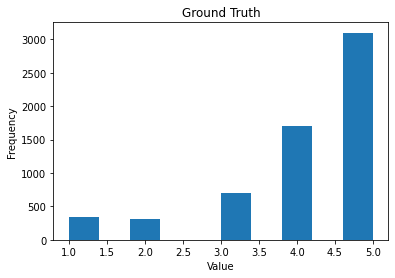

In [0]:
getHistogram('ratingScore', 'Ground Truth')

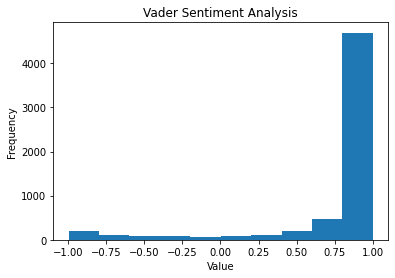

In [0]:
getHistogram('vader', 'Vader Sentiment Analysis')

There are some slight differences in the two histograms. Ground Truth does a better job at showcasing the different rating of the hotels whereas Vader Analysis makes it tough to distinguish between the different hotels (most of them have a Vader score greater than 0.8). This could also be due to the fact that most of the hotel ratings are between 3-5. The neutral revies could have some positive terms too.

It is also important to note that two are being compared on different scales.

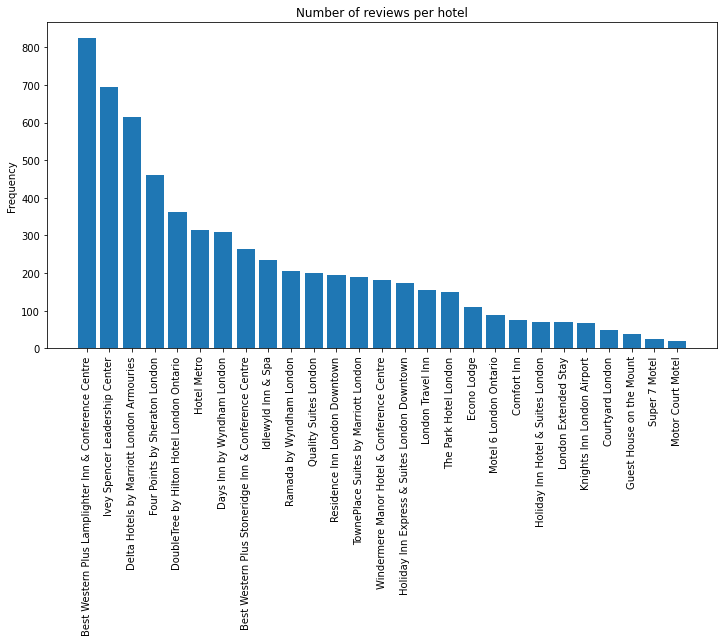

In [0]:
plt.figure(figsize= (12,6))
hotel_review= dict(hotelDf.hotelName.value_counts())
x= hotel_review.keys()
y= hotel_review.values()
plt.bar(x,y)
plt.ylabel('Frequency')
plt.title('Number of reviews per hotel')
plt.xticks(rotation= 90)
plt.show()

This is an expected result as London, Ontario is not a popular city and hence some of the hotels do not have many reviews.

However, most of the hotels have more than 100 reviews.

Note: 8 hotels were eliminated from the intial data because they had less than 20 reviews.

### (b) Boxplots

In [0]:
hotelNames = finalDf['hotelName'].unique()
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pd.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

#### Ground Truth Rating boxplot

In [0]:
hotelRatingDfGt = getHotelRank(finalDf)

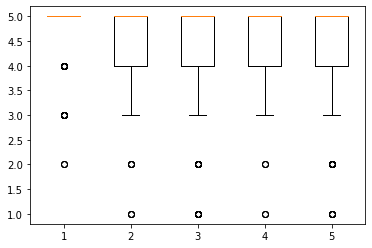

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

idlewyld_gt = finalDf.loc[finalDf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
hotel_metro_gt = finalDf.loc[finalDf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
best_western_gt = finalDf.loc[finalDf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
townePlace_gt = finalDf.loc[finalDf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
ivey_gt = finalDf.loc[finalDf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data_gt = [idlewyld_gt, hotel_metro_gt, best_western_gt, townePlace_gt, ivey_gt]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_gt)
plt.show()

#### Vader boxplot

In [0]:
hotelRatingDfVd = getHotelRank(finalDf, measure='vader')

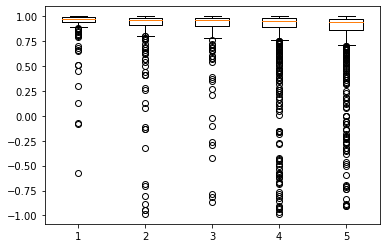

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5vdhotel = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5vdhotel['hotelName'].values

idlewyld_vd = finalDf.loc[finalDf['hotelName'] == tp5vdhotel['hotelName'].values[0]]['vader']
hotel_metro_vd = finalDf.loc[finalDf['hotelName'] == tp5vdhotel['hotelName'].values[1]]['vader']
windermere_vd = finalDf.loc[finalDf['hotelName'] == tp5vdhotel['hotelName'].values[2]]['vader']
best_western_vd = finalDf.loc[finalDf['hotelName'] == tp5vdhotel['hotelName'].values[3]]['vader']
ivey_vd = finalDf.loc[finalDf['hotelName'] == tp5vdhotel['hotelName'].values[4]]['vader']

data_vd = [idlewyld_vd, hotel_metro_vd, windermere_vd, best_western_vd, ivey_vd]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_vd)
plt.show()

#### Mean and Variance

In [0]:
print("Ground truth rating Mean and Variance:\n")
for i in range (0,5):
  print("Hotel %d: Mean_GT= %0.3f, Var_GT= %0.3f" %(i+1, data_gt[i].mean(), data_gt[i].var()))

print("\nVader Mean and Variance:\n")
for i in range (0,5):
  print("Hotel %d: Mean_Vader= %0.3f, Var_Vader= %0.3f" %(i+1, data_vd[i].mean(), data_vd[i].var()))

Ground truth rating Mean and Variance:

Hotel 1: Mean_GT= 4.732, Var_GT= 0.368
Hotel 2: Mean_GT= 4.562, Var_GT= 0.604
Hotel 3: Mean_GT= 4.499, Var_GT= 0.726
Hotel 4: Mean_GT= 4.453, Var_GT= 0.704
Hotel 5: Mean_GT= 4.416, Var_GT= 0.733

Vader Mean and Variance:

Hotel 1: Mean_Vader= 0.931, Var_Vader= 0.029
Hotel 2: Mean_Vader= 0.866, Var_Vader= 0.099
Hotel 3: Mean_Vader= 0.852, Var_Vader= 0.100
Hotel 4: Mean_Vader= 0.840, Var_Vader= 0.114
Hotel 5: Mean_Vader= 0.822, Var_Vader= 0.109


Box Plots are more informative and easier to interpret than just the mean and variance values. Boxplots are more useful in identifying the outliers as well.

### (c) Scatterplots and heatmap

#### Ground truth vs Vader score

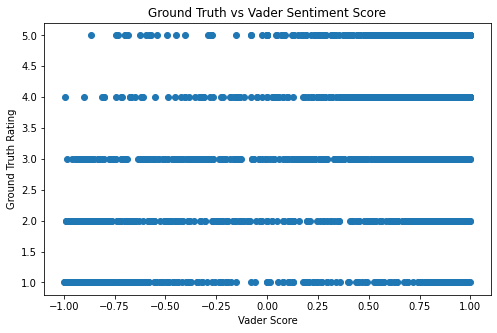

In [0]:
y = finalDf['ratingScore'].values
x = finalDf['vader'].values
plt.figure(figsize=(8,5))
plt.plot(x, y,"o")
plt.ylabel('Ground Truth Rating')
plt.xlabel('Vader Score')
plt.title('Ground Truth vs Vader Sentiment Score')
plt.show()

In [0]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

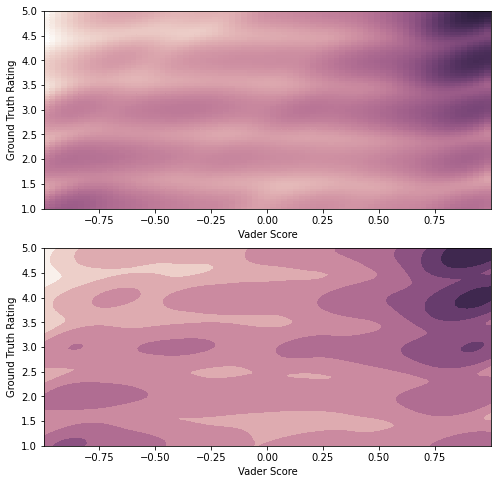

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Ground Truth Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Ground Truth Rating')
plt.show()

It is quite evident from both the scatter and heatmaps that the higher ground truth rating usually mean a higher vader score. This is because people who usually give 5 stars use words such as great, excellent, etc.

However, there are still some instances when the ground truth rating is low while the vader is score is high. This is because of the subtlety in some of the human reviews. The neural reviews could contain both positive and negative terms. It could also mean that some people are hard to please even if their experience was good. 

Vader sentiment scores are good to understand the potential reasons for the negative or positive sentiment. However, it is important to note that they do not always reflect the actual ground truth rating.

#### Length of reviews vs Ground truth rating/Vader score



In [0]:
finalDf['lengthOfReview'] = [len(review) for review in finalDf['reviewCol']]

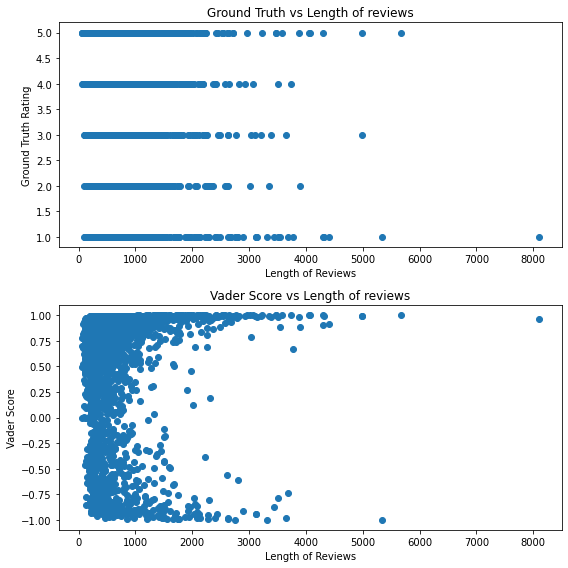

In [0]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

x1 = finalDf['lengthOfReview'].values
y1 = finalDf['ratingScore'].values

ax1.plot(x1, y1,"o")
ax1.set_ylabel('Ground Truth Rating')
ax1.set_xlabel('Length of Reviews')
ax1.set_title('Ground Truth vs Length of reviews')

x2 = finalDf['lengthOfReview'].values
y2 = finalDf['vader'].values

ax2.plot(x2,y2,"o")
ax2.set_ylabel('Vader Score')
ax2.set_xlabel('Length of Reviews')
ax2.set_title('Vader Score vs Length of reviews')

plt.tight_layout()
plt.show()

In [0]:
from scipy.stats.kde import gaussian_kde

k1 = gaussian_kde(np.vstack([x1, y1]))
xi1, yi1 = np.mgrid[x1.min():x1.max():x1.size**0.5*1j,y1.min():y1.max():y1.size**0.5*1j]
zi1 = k1(np.vstack([xi1.flatten(), yi1.flatten()]))

In [0]:
k2 = gaussian_kde(np.vstack([x2, y2]))
xi2, yi2 = np.mgrid[x2.min():x2.max():x2.size**0.5*1j,y2.min():y2.max():y2.size**0.5*1j]
zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))

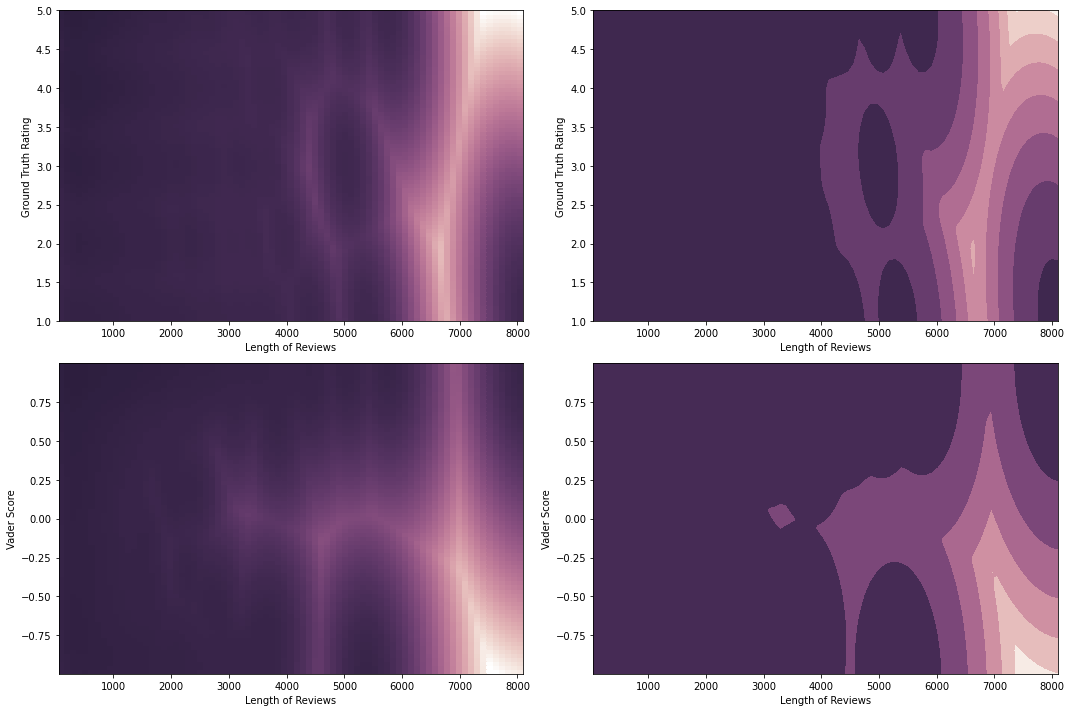

In [0]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.pcolormesh(xi1, yi1, np.log10(zi1.reshape(xi1.shape)), cmap=cmap)
ax2.contourf(xi1, yi1, np.log10(zi1.reshape(xi1.shape)), cmap=cmap)
ax3.pcolormesh(xi2, yi2, np.log10(zi2.reshape(xi2.shape)), cmap=cmap)
ax4.contourf(xi2, yi2, np.log10(zi2.reshape(xi2.shape)), cmap=cmap)

ax1.set_xlim(x1.min(), x1.max())
ax1.set_ylim(y1.min(), y1.max())
ax2.set_xlim(x1.min(), x1.max())
ax2.set_ylim(y1.min(), y1.max())

ax3.set_xlim(x2.min(), x2.max())
ax3.set_ylim(y2.min(), y2.max())
ax4.set_xlim(x2.min(), x2.max())
ax4.set_ylim(y2.min(), y2.max())

ax1.set_xlabel('Length of Reviews')
ax1.set_ylabel('Ground Truth Rating')

ax2.set_xlabel('Length of Reviews')
ax2.set_ylabel('Ground Truth Rating')

ax3.set_xlabel('Length of Reviews')
ax3.set_ylabel('Vader Score')

ax4.set_xlabel('Length of Reviews')
ax4.set_ylabel('Vader Score')

plt.tight_layout()
plt.show()

It can be noticed that negative reviews are usually associated with a higher length of review. People usually have a lot to write to convey dissatisfaction. For ground truth rating, ratings of 4 and 5 seem to have a lower length of revies when compared to the lower ratings.

Vader sentiment seems to be different in the sence that the higher vader score can be found when there is a higher length of review. This could be because people who express dissatisfaction in a lot of words might be subtle and use words such as not great, or not good instead of extreme words such as terrible, or bad. Hence vader score might not be able to interpret the negative sentiment in all cases.

#### Number of reviews per hotel vs Ground truth rating/vader score

In [0]:
sentimentAnalysisDf.head()

,ratingScore,vader
hotelName,,
Best Western Plus Lamplighter Inn & Conference Centre,4.499394,0.839944
Best Western Plus Stoneridge Inn & Conference Centre,4.147170,0.769336
Comfort Inn,3.413333,0.643128
Courtyard London,4.000000,0.586474
Days Inn by Wyndham London,3.306452,0.485699


In [0]:
hotel_review

{'Best Western Plus Lamplighter Inn & Conference Centre': 825,
 'Best Western Plus Stoneridge Inn & Conference Centre': 265,
 'Comfort Inn': 75,
 'Courtyard London': 50,
 'Days Inn by Wyndham London': 310,
 'Delta Hotels by Marriott London Armouries': 614,
 'DoubleTree by Hilton Hotel London Ontario': 362,
 'Econo Lodge': 111,
 'Four Points by Sheraton London': 460,
 'Guest House on the Mount': 37,
 'Holiday Inn Express & Suites London Downtown': 175,
 'Holiday Inn Hotel & Suites London': 71,
 'Hotel Metro': 315,
 'Idlewyld Inn & Spa': 235,
 'Ivey Spencer Leadership Center': 695,
 'Knights Inn London Airport': 68,
 'London Extended Stay': 70,
 'London Travel Inn': 156,
 'Motel 6 London Ontario': 90,
 'Motor Court Motel': 20,
 'Quality Suites London': 200,
 'Ramada by Wyndham London': 205,
 'Residence Inn London Downtown': 196,
 'Super 7 Motel': 24,
 'The Park Hotel London': 150,
 'TownePlace Suites by Marriott London': 190,
 'Windermere Manor Hotel & Conference Centre': 183}

In [0]:
hotel_per_rating= [sentimentAnalysisDf.loc[x].ratingScore for x in hotel_review.keys()]
hotel_per_vader= [sentimentAnalysisDf.loc[x].vader for x in hotel_review.keys()]

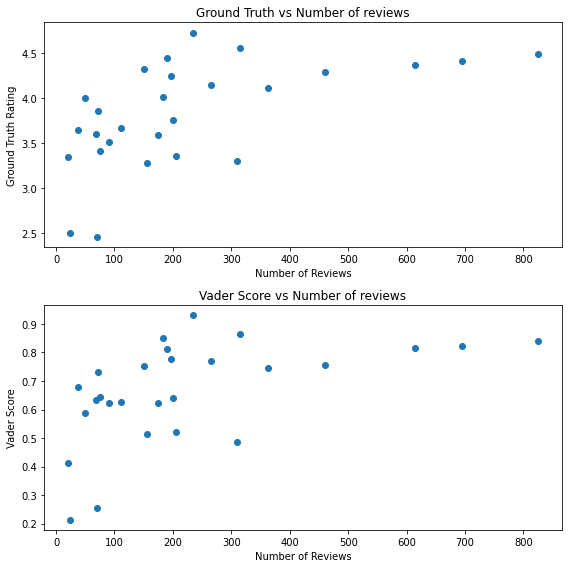

In [0]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

x1 = list(hotel_review.values())
y1 = hotel_per_rating

ax1.plot(x1, y1,"o")
ax1.set_ylabel('Ground Truth Rating')
ax1.set_xlabel('Number of Reviews')
ax1.set_title('Ground Truth vs Number of reviews')

x2 = list(hotel_review.values())
y2 = hotel_per_vader

ax2.plot(x2,y2,"o")
ax2.set_ylabel('Vader Score')
ax2.set_xlabel('Number of Reviews')
ax2.set_title('Vader Score vs Number of reviews')

plt.tight_layout()
plt.show()

It is evident that the hotels with fewer ratings had lower rating and lower vader score. This could be because the ratings and vader score are biased by reviews from few people. The results generalize better when the number of reviews increases.

Note that the hotels with fewer than 20 reviews were eliminated in the Data Cleaning stage.